In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston
import pickle
import pandas as pd
import skopt.space
from skopt import gp_minimize
from skopt import gbrt_minimize
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import binom_test
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost.sklearn import XGBRegressor
from functools import partial
from sklearn.ensemble import GradientBoostingRegressor

/home/mahasen/anaconda3/envs/gh2018/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

#### Add parameter constraints
We reasonably expect that the number of tax returns filed should increase with number of tax centers. We can impose these constraints as follows:

```params_constrained = params.copy()
params_constrained['monotone_constraints'] = "(1,-1)"
model_with_constraints = xgb.train(params_constrained, dtrain,                               num_boost_round = 1000, evals = evallist,early_stopping_rounds = 10)```
                                   
where `(1,-1)` means constrain the 1st variable to be monotonically increasing w.r.t. loss, and decreasing in the 2nd.

It is reasonable to expect that the presence of a tax center would increase and not reduce the number of tax returns filed.

#### Add GBRT as hyperparameter optimiser
DONE

# EZ2
## EZ2 Plan
Inputs : vector of things (ATO/ABS variables on each postcode)
Target : number of tax returns filed in that postcode

- Train model on the above, applying a constraint of monotonicity in number of tax returns as a function of number of tax centers.
- Run model on each suburb, keeping all variables constant, except tax center which is incremented by 1, get predicted number of tax returns
- Get the difference between predicted and 2016 tax return numbers and multiply each by the average taxable income of that suburb
- Rank suburbs by this quantity
- Export as JSON



### Functions

In [5]:
# model builder
def build_model(monotone_constraints=None):
    max_depth = 3
    learning_rate = 0.1
    n_estimators = 100
    objective = "reg:linear"
    booster = 'gbtree'
    gamma = 0.1 # default = 0, min loss required to add new leaf, increasing makes model more conservative
    subsample = 1 # subsample of the training instance
    colsample_bytree = 1 # Subsample ratio of columns when constructing each tree.
    reg_alpha = 0 # try 1?
    reg_lambda = 1
    silent = True
    
    if monotone_constraints is None:
        model = xgb.XGBRegressor(max_depth = max_depth,
                                 learning_rate = learning_rate,
                                 n_estimators = n_estimators,
                                 silent = silent,
                                 objective = objective,
                                 booster = booster,
                                 gamma = gamma,
                                 subsample = subsample,
                                 colsample_bytree = colsample_bytree,
                                 reg_alpha = reg_alpha,
                                 reg_lambda = reg_lambda)
    else:
        model = xgb.XGBRegressor(max_depth = max_depth,
                                 learning_rate = learning_rate,
                                 n_estimators = n_estimators,
                                 silent = silent,
                                 objective = objective,
                                 booster = booster,
                                 gamma = gamma,
                                 subsample = subsample,
                                 colsample_bytree = colsample_bytree,
                                 reg_alpha = reg_alpha,
                                 reg_lambda = reg_lambda,
                                 monotone_constraints = monotone_constraints)
    
    return model

# grid search hyperparameter optimiser
def hyperparameter_opt_GridSearch(model,parameter_dict,data,target):
    clf = GridSearchCV(model, parameter_dict, verbose=1)
    clf.fit(data,target)
    print(clf.best_score_)
    print(clf.best_params_)
    
    return clf

# GBRT hyperparameter optimiser
def hyperparameter_opt_GBRT(model,parameter_space,data, target, n_calls=50):
    
    # Build objective function
    @use_named_args(parameter_space)
    def objective(**params):
        model.set_params(**params)
    
        return -np.mean(cross_val_score(model,data,target,
                    n_jobs=-1,scoring="neg_mean_absolute_error"))
    
    clf = gbrt_minimize(objective, parameter_space, n_calls=50, random_state=0,verbose=True)
    
    print(clf.x)
    return clf

# Quantile regression, from https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b
class XGBOOSTQUANTILE(BaseEstimator, RegressorMixin):
    def __init__(self, quant_alpha,quant_delta,quant_thres,quant_var,
    n_estimators = 100,max_depth = 3,reg_alpha = 5.,reg_lambda=1.0,gamma=0.5):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta 
        self.quant_thres = quant_thres 
        self.quant_var = quant_var 
        #xgboost parameters 
        self.n_estimators = n_estimators 
        self.max_depth = max_depth 
        self.reg_alpha= reg_alpha 
        self.reg_lambda = reg_lambda 
        self.gamma = gamma 
        #keep xgboost estimator in memory 
        self.clf = None
    def fit(self, X, y): 
        def quantile_loss(y_true, y_pred,_alpha,_delta,_threshold,_var): 
            x = y_true - y_pred 
            grad = (x<(_alpha-1.0)*_delta)*(1.0-_alpha)- ((x>=(_alpha-1.0)*_delta)&
                                    (x<_alpha*_delta) )*x/_delta-_alpha*(x>_alpha*_delta) 
            hess = ((x>=(_alpha-1.0)*_delta)& (x<_alpha*_delta) )/_delta 
            _len = np.array([y_true]).size 
            var = (2*np.random.randint(2, size=_len)-1.0)*_var 
            grad = (np.abs(x)<_threshold )*grad - (np.abs(x)>=_threshold )*var 
            hess = (np.abs(x)<_threshold )*hess + (np.abs(x)>=_threshold ) 
            return grad, hess 
        self.clf = XGBRegressor(
                             objective=partial( quantile_loss,
                            _alpha = self.quant_alpha,
                            _delta = self.quant_delta,
                            _threshold = self.quant_thres,
                            _var = self.quant_var), 
                            n_estimators = self.n_estimators,
                            max_depth = self.max_depth,
                            reg_alpha =self.reg_alpha, 
                            reg_lambda = self.reg_lambda,
                            gamma = self.gamma,
                            booster = 'dart')
        self.clf.fit(X,y) 
        return self
    def predict(self, X): 
        y_pred = self.clf.predict(X) 
        return y_pred 
    def score(self, X, y): 
        y_pred = self.clf.predict(X) 
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y<y_pred)+self.quant_alpha*(y-y_pred)* (y>=y_pred) 
        score = 1./np.sum(score) 
        return score

# Test

In [6]:
rng = np.random.RandomState(31337)
print("Boston Housing: regression")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

Boston Housing: regression
22.247195111946144
9.914663303584955


In [7]:
print("Parameter optimization")
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
parameters = {'max_depth': [2,4,6],'n_estimators': [50,100,200],'booster': ['gbtree','gblinear','dart']}
clf = GridSearchCV(xgb_model, parameters, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.5984879606490934
{'booster': 'gbtree', 'max_depth': 4, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    4.6s finished


In [8]:
space = [skopt.space.Integer(3,6, name='max_depth'),
         skopt.space.Integer(50,200, name='n_estimators'),
         skopt.space.Real(0,1,name='gamma'),
         skopt.space.Categorical(['gbtree','dart'],name='booster')]

@use_named_args(space)
def objective(**params):
    xgb_model.set_params(**params)
    
    return -np.mean(cross_val_score(xgb_model,X,y,
                    n_jobs=-1,scoring="neg_mean_absolute_error"))

In [ ]:
hyperparameter_opt_GBRT(xgb_model,space, X, y)

#res_gp = gbrt_minimize(objective, space, n_calls=50, random_state=0)
#"Best score=%.4f" % res_gp.fun

# Cleaning EZ0
First we need to remove superfluous columns.

Then we need to convert categorical variables to an equivalent one-hot encoding since xgboost will interpret numeric data as numeric and not categorical.

Some variables are actually numeric, e.g. year, 'Debtor Income', Unsecured Debts, Value of Assets (which are income bins that we can replace with the value of the center of the bin)

In [ ]:
df_ez0 = pd.read_csv('./govhack2018-EZ0/data/preprocess/non-compliance-major-group.csv')

In [ ]:
df_ez0_sml = df_ez0.copy()

In [ ]:
df_ez0_sml = df_ez0_sml.drop(columns=['SA3 of Debtor', 'GCCSA of Debtor','GCCSA Code of Debtor','State of Debtor',
                                      'Type of Party','Non-Compliance Type','Result of Non-Compliance','Number of Instances',
                                      'Outcome of Non-Compliance','Non-Compliance Conviction Result','Debtor Occupation Name (ANZSCO)','Debtor Occupation Code (ANZSCO)'])

In [ ]:
df_ez0_sml['Debtor Income'].unique()

In [ ]:
pd.get_dummies(df_ez0_sml,prefix=['SA3 Code of Debtor', 'Sex of Debtor'])

In [ ]:
tmp = pd.get_dummies(df_ez0_sml['Main Cause of Insolvency'],prefix='Main Cause of Insolvency')

In [ ]:
df_ez0_sml

# Processing EZ2

In [9]:
df_ez2 = pd.read_csv('./govhack2018-EZ2/munging/ez2munge_0_ato_only.csv')

In [10]:
# Convert to Postcode, x_data, y_data
ez2_postcode = df_ez2['Postcode'].values

# Set input and target columns and separate dataframes
df_ez2_xdata = df_ez2[['Count','Net tax','Taxable income or loss1 ',
                       'Net rent','Net capital gain','Total income or loss','Total deductions','Salary or wages','Medicare levy','Medicare levy surcharge','Total work related expenses','Gifts or donations','HELP assessment debt2']]
df_ez2_ydata = df_ez2['Individuals1']

### Build model

In [11]:
xdg_model_ez2 = xgb.XGBRegressor(max_depth=4, n_estimators=1000, booster='dart',monotone_constraints=(1,0,0,0,0,0,0,0,0,0,0,0,0)) # parameters obtained from optimisation at bottom of notebook

### Construct test/train data

In [12]:
X = df_ez2_xdata.as_matrix()
y = df_ez2_ydata.values
X_train, X_test, y_train, y_test = train_test_split(df_ez2_xdata.as_matrix(), df_ez2_ydata.values , test_size=0.2)

/home/mahasen/anaconda3/envs/gh2018/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/mahasen/anaconda3/envs/gh2018/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


# Train

In [13]:
#clf = xdg_model_ez2.fit(X_train,y_train)
clf = xdg_model_ez2.fit(X_train,y_train)
predictions_train = xdg_model_ez2.predict(X_train)
predictions_test = xdg_model_ez2.predict(X_test)

# The test/train divergence isn't great, but it'll do as a first iteration
print(math.sqrt(mean_squared_error(y_train, predictions_train)))
print(math.sqrt(mean_squared_error(y_test, predictions_test)))

30.003235306088715
1490.7286440815124


### Add a tax center to each postcode and rank by number of new tax returns and percentage increase

In [14]:
# Create new inpute where all variables are fixed except for the number of tax centers, which is incremented by 1
df_ez2_xdata_addTaxCenter = df_ez2_xdata.as_matrix()
df_ez2_xdata_addTaxCenter[:,0] = df_ez2_xdata_addTaxCenter[:,0] + 1

/home/mahasen/anaconda3/envs/gh2018/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [17]:
# Get predictions of number of individuals filling tax returns
individuals_withNewTaxCenter = xdg_model_ez2.predict(df_ez2_xdata_addTaxCenter)
newIndividuals_withNewTaxCenter = individuals_withNewTaxCenter - df_ez2_ydata.values
newIndividuals_withNewTaxCenter = np.maximum(newIndividuals_withNewTaxCenter,0)

# Get percentage increase of individuals filling tax returns
newIndividuals_withNewTaxCenter_percentage = np.divide(newIndividuals_withNewTaxCenter,df_ez2_ydata.values)*100

# Stack
print(np.stack([ez2_postcode,newIndividuals_withNewTaxCenter,newIndividuals_withNewTaxCenter_percentage],axis=1))

[[8.00000000e+02 3.94997559e+02 7.22909148e+00]
 [8.01000000e+02 3.33830566e+02 3.92280337e+01]
 [8.04000000e+02 1.50126984e+02 7.62065907e+01]
 ...
 [7.46800000e+03 1.51997314e+02 3.67143272e+01]
 [7.46900000e+03 1.36540710e+02 3.86800879e+01]
 [7.47000000e+03 1.43608582e+02 4.47378759e+01]]


In [59]:
def normalise_data(x):
    # Normalises to (-1,1)
    norm = np.max(x)-np.min(x)
    x_norm = 2*(x-np.min(x))/norm - 1.0
    
    return x_norm

def vec_in_range(v,a,b):
    return ((a<=v)&(v<=b))
    

In [51]:
# Define colormap indices
newIndividuals_withNewTaxCenter_cmap = normalise_data(newIndividuals_withNewTaxCenter)
newIndividuals_withNewTaxCenter = newIndividuals_withNewTaxCenter.astype(np.int)

newIndividuals_withNewTaxCenter_percentage_cmap = normalise_data(newIndividuals_withNewTaxCenter_percentage)

# Create dataaframe containing predictions. Populate all other postcodes for ease of visualisation
ez2_postcode_complement = list(set(range(0,9999)).difference(set(ez2_postcode)))
d = {'postcode': ez2_postcode, 'deltaPeople': newIndividuals_withNewTaxCenter,'deltaPeoplePC':newIndividuals_withNewTaxCenter_percentage,
    'deltaPeople_color': newIndividuals_withNewTaxCenter_cmap,'deltaPeoplePC_color':newIndividuals_withNewTaxCenter_percentage_cmap}
d_complement = {'postcode': ez2_postcode_complement, 'deltaPeople': np.zeros(shape=len(ez2_postcode_complement)),'deltaPeoplePC': np.zeros(shape=len(ez2_postcode_complement)),
                'deltaPeople_color': np.zeros(shape=len(ez2_postcode_complement)),'deltaPeoplePC_color':np.zeros(shape=len(ez2_postcode_complement))}
output_df = pd.DataFrame(d)
output_df_complement = pd.DataFrame(d_complement)
output_df_complete = pd.concat([output_df,output_df_complement])
output_df_complete_json = output_df_complete.set_index('postcode')

In [93]:
json_str = output_df_complete_json.to_json(orient='index')
with open('ez2_results_model_small.json', 'w') as file:
    file.write(json_str)

In [34]:
# Aggregate at state level

In [61]:
v = output_df_complete['postcode']
conditions = [
    vec_in_range(v,1000,1999) | vec_in_range(v,2000,2599) | vec_in_range(v,2619,2899) | vec_in_range(v,2921,2999),
    vec_in_range(v,200,299) | vec_in_range(v,2600,2618) | vec_in_range(v,2900,2920),
    vec_in_range(v,3000,3999) | vec_in_range(v,8000,8999),
    vec_in_range(v,4000,4999) | vec_in_range(v,9000,9999), 
    vec_in_range(v,5000,5799) | vec_in_range(v,5800,5999),
    vec_in_range(v,6000,6797) | vec_in_range(v,6800,6999),
    vec_in_range(v,7000,7799) | vec_in_range(v,7800,7999),
    vec_in_range(v,800,899) | vec_in_range(v,900,999)
]
choices = ['NSW','ACT','VIC','QLD','SA','WA','TAS','NT']

output_df_complete['State'] = np.select(conditions,choices, default='none')

In [86]:
aggregated_states = [np.sum(output_df_complete[output_df_complete['State']==i]['deltaPeople'].values) for i in choices]
state_populations = [7317500,366900,5640900,4599400,1659800,2366900,511000,231200]
aggregated_states_prop = np.divide(aggregated_states,state_populations)

aggregated_states_cmap = normalise_data(aggregated_states)
aggregated_states_prop_cmap = normalise_data(aggregated_states_prop)

In [89]:
aggregated_states_dict = {'State':choices,'deltaPeople':aggregated_states,'deltaPeoplePC':aggregated_states_prop,
                     'deltaPeople_color':aggregated_states_cmap,'deltaPeoplePC_color':aggregated_states_prop_cmap}
aggregated_states_df = pd.DataFrame(aggregated_states_dict)

In [92]:
json_str = aggregated_states_df.to_json(orient='index')
with open('ez2_results_model_small_stateAggregated.json', 'w') as file:
    file.write(json_str)

### Check predictions
Let's plot the predictions against postcode (this isn't completely pointless, since postcodes are organised by state each 1000, with more cosmopolitan areas closer to the nearest 1000).
Note that while the overwhelming majority of points have a predicted increase in the number of 

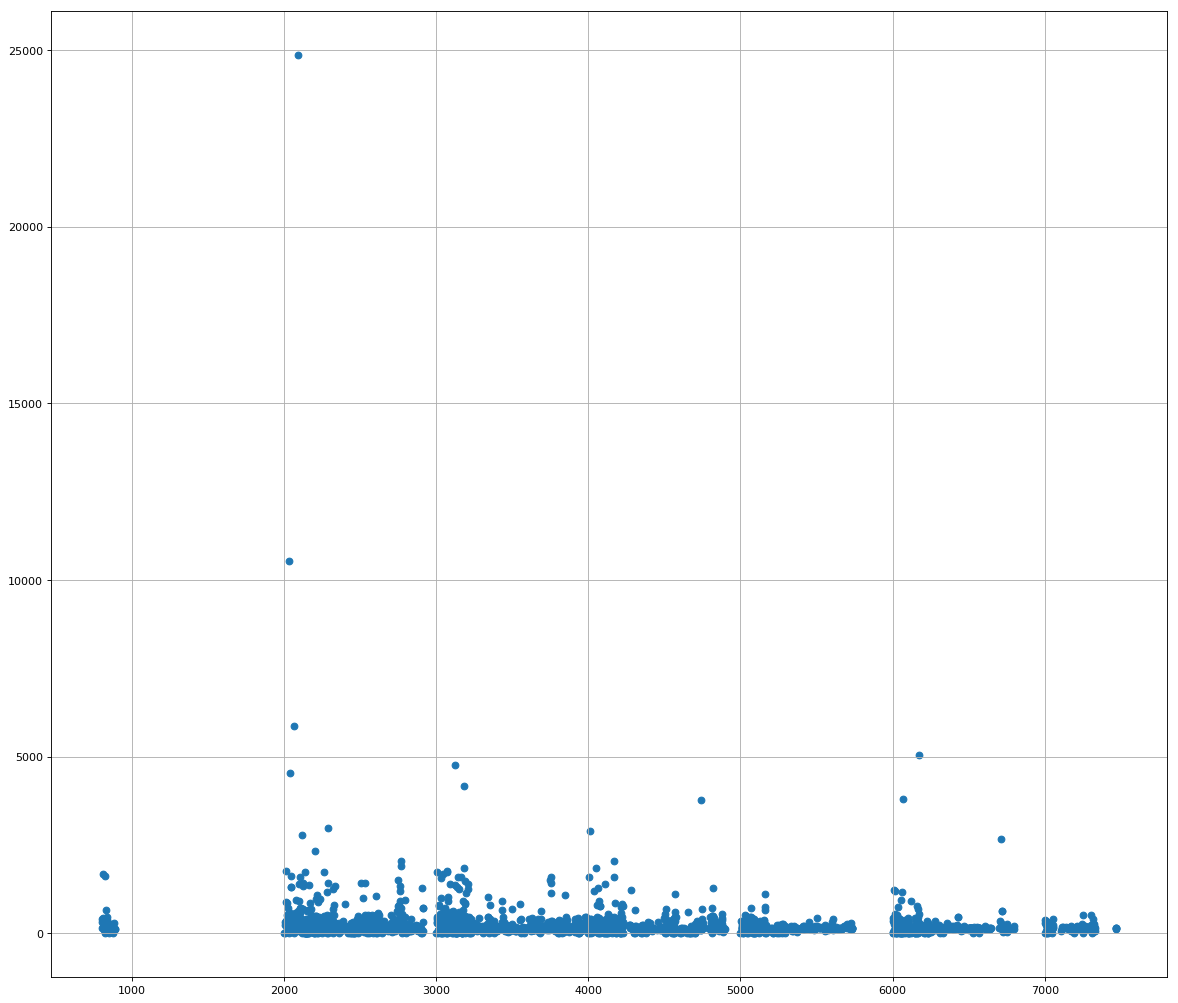

In [16]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(ez2_postcode,newIndividuals_withNewTaxCenter)
plt.grid()
plt.show()

In [ ]:
## Prediction Intervals for Gradient Boosting Regression, adpted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
alpha = 0.95
clf_qpi = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=50, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf = xdg_model_ez2.fit(X_train,y_train)
dy = 1.5 + 1.0 * np.random.random(y_train.shape)
noise = np.random.normal(0, dy)
y_noise = noise +np.array(y_train)
#y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
clf_qpi.fit(X_train, y_train)

# Make the prediction on the meshed x-axis
y_upper = clf_qpi.predict(X)

clf_qpi.set_params(alpha=1.0 - alpha)
clf_qpi.fit(X_train, y_noise)

# Make the prediction on the meshed x-axis
y_lower = clf_qpi.predict(X)

clf_qpi.set_params(loss='ls')
clf_qpi.fit(X_train, y_noise)

# Make the prediction on the meshed x-axis
y_pred = clf_qpi.predict(X)

In [ ]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#plt.scatter(ez2_postcode, y)
plt.errorbar(ez2_postcode, y_pred, yerr=[y_lower, y_upper],fmt='o', ecolor='k',capthick=1)
plt.show()

In [534]:
# Let's use the XGBoost specific example
# First the noiseless case
dy = 1.5 + 1.0 * np.random.random(y_train.shape)
noise = np.random.normal(0, dy)
y_noise = np.array(y_train).astype(np.float64)
y_noise += noise

alpha = 0.6
xgb_main    = xgb.XGBRegressor(n_estimators = 200,max_depth = 5,reg_alpha = 5.,reg_lambda=1.0,gamma=0.50, booster='dart',monotone_constraints=(1,0,0,0,0,0,0,0,0,0,0,0,0)) 
xgb_quant_u = XGBOOSTQUANTILE(alpha , 1.0, 6.0, 30000,n_estimators = 200,max_depth = 5,reg_alpha = 1.,reg_lambda=1.0,gamma=0.5)
xgb_quant_l = XGBOOSTQUANTILE(1-alpha , 1.0, 6.0, 30000,n_estimators = 200,max_depth = 5,reg_alpha = 1.,reg_lambda=1.0,gamma=0.5)

xgb_main.fit(X_train,y_train)
xgb_quant_u.fit(X_train,np.round(y_noise).astype(np.int))
xgb_quant_l.fit(X_train,np.round(y_noise).astype(np.int))

X_add = X
X[:,0] = X[:,0] + 10
y_pred = xgb_main.predict(X_add) - y 
y_pred_l = xgb_quant_u.predict(X_add)
y_pred_u = xgb_quant_l.predict(X_add)


In [537]:
y_pred+y

array([5869.45605469, 1056.32971191,  386.29714966, ...,  547.11584473,
        462.54418945,  460.41757202])

In [538]:
y_pred_l

array([ 2803.9236, 11376.291 , 19422.395 , ..., 15932.896 , 20402.271 ,
       22501.887 ], dtype=float32)

In [539]:
y_pred_u

array([24191.26   , -3439.6104 , 21056.47   , ...,   712.46545,
        2907.3093 , 23518.297  ], dtype=float32)

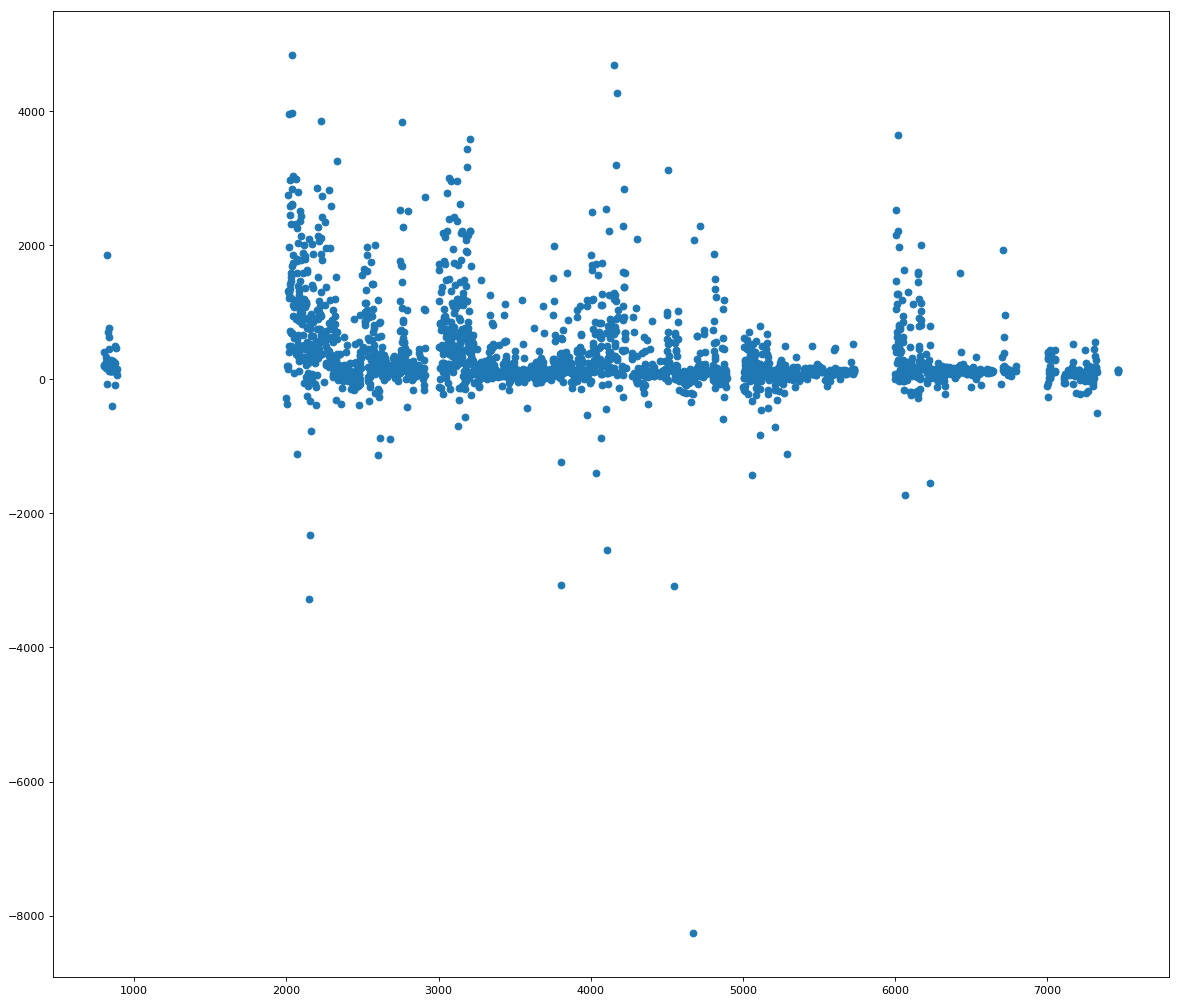

In [540]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#plt.scatter(ez2_postcode, y)
#plt.errorbar(ez2_postcode, y_pred, yerr=[y_pred_u, y_pred_l],fmt='o', ecolor='k',capthick=1)
plt.scatter(ez2_postcode, y_pred)
plt.show()

In [372]:
xgb_quant_l.score(X,y)

AttributeError: 'NoneType' object has no attribute 'predict'

### Hyperparameter optimisation

In [242]:
print(xdg_model_ez2.predict([1,101020407.0,3.893756e+08,-4580471.0,2352866.0,4.019841e+08,12492549.0,3.690974e+08,5273096.0,290409.0,9884768.0,497103.0,1065946.0]))
print(xdg_model_ez2.predict([0,101020407.0,3.893756e+08,-4580471.0,2352866.0,4.019841e+08,12492549.0,3.690974e+08,5273096.0,290409.0,9884768.0,497103.0,1065946.0]))

[5836.321]
[5442.007]


In [210]:
xdg_model_ez2.predict(X_train[0,:].reshape([1,13]))

array([10356606.], dtype=float32)

In [173]:
space = [skopt.space.Integer(3,6, name='max_depth'),
         skopt.space.Integer(50,200, name='n_estimators'),
         skopt.space.Real(0,1,name='gamma'),
         skopt.space.Categorical(['gbtree','dart'],name='booster')]

In [174]:
hyperparameter_opt_GBRT(xdg_model_ez2,space, X_train, y_train)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7217
Function value obtained: 5333973.4014
Current minimum: 5333973.4014
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6164
Function value obtained: 5153594.5825
Current minimum: 5153594.5825
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8876
Function value obtained: 5155056.1997
Current minimum: 5153594.5825
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7635
Function value obtained: 5210208.9329
Current minimum: 5153594.5825
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5359
Function value obtained: 5490130.9181
Curre

          fun: 5054991.4694823325
    func_vals: array([5333973.40142257, 5153594.58250037, 5155056.19967343,
       5210208.9329466 , 5490130.91811747, 5164934.08834387,
       5527519.50815969, 5853110.55752395, 5101508.77316473,
       5290575.43352884, 5083348.20890577, 5146458.37473241,
       5079284.01908372, 5080345.64556069, 5307196.5604395 ,
       5295395.32504461, 5078865.2898667 , 5081393.42085663,
       5057219.55649822, 5185971.09356493, 5057219.55649822,
       5057219.64795926, 5057219.64795926, 5057219.55649822,
       5057219.55649822, 5868238.20559704, 5057219.64795926,
       6026183.99867595, 5057219.64795926, 6026183.99867595,
       5322065.75372576, 6026183.99867595, 5079436.40683393,
       5079436.03514265, 5678214.7718231 , 5055535.38840861,
       5280941.7154003 , 5271016.25510687, 5224486.26769415,
       5319595.25489564, 5219773.76770077, 5224486.26769415,
       5057219.64795926, 5079436.40683393, 5054991.46948233,
       5224486.26769415, 5079436.035